In [1]:
from loader.Pouring_dataset import Pouring
from models.mmp import MMP, NRMMP
from models.modules import FC_SE32vec, FC_vec2SE3

import matplotlib.pyplot as plt
import scipy
import torch

device = f'cuda:0'

In [2]:
encoder1 = FC_SE32vec(
    in_chan=480*12,
    out_chan=2,
    l_hidden=[2048, 1024, 512, 256, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
decoder1 = FC_vec2SE3(
    in_chan=2,
    out_chan=480*6,
    l_hidden=[256, 512, 1024, 2048, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
encoder2 = FC_SE32vec(
    in_chan=480*12,
    out_chan=2,
    l_hidden=[2048, 1024, 512, 256, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
decoder2 = FC_vec2SE3(
    in_chan=2,
    out_chan=480*6,
    l_hidden=[256, 512, 1024, 2048, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
mmp = MMP(encoder1, decoder1)
mmp.to(device)
nrmmp = NRMMP(encoder2, decoder2, approx_order=1, kernel={'type': 'binary', 'lambda':0.1})
nrmmp.to(device)

load_dict = torch.load("results/mmp.pkl", map_location='cpu')
ckpt = load_dict["model_state"]
mmp.load_state_dict(ckpt)

load_dict = torch.load("results/nrmmp.pkl", map_location='cpu')
ckpt = load_dict["model_state"]
nrmmp.load_state_dict(ckpt)

<All keys matched successfully>

In [3]:
ds = Pouring()

Pouring dataset is ready; # of trajectories: 10


In [4]:
mmp_encoded_data = mmp.encode(ds.traj_data_.to(device)).detach().cpu()
nrmmp_encoded_data = nrmmp.encode(ds.traj_data_.to(device)).detach().cpu()

In [5]:
ts_coordinates = ds.labels_[:, [0, 2]].to(torch.float32)
ts_coordinates[:, -1] = (ts_coordinates[:, 1] - 1)/4

In [6]:
def reparametrize(ts, ts_coordinates, encoded_data):
    # ts : (Len, 2)
    # ts_coordinates : (bs, 2)
    # encoded_data : (bs, 2)
    
    z1_val = scipy.interpolate.griddata(
        ts_coordinates, 
        encoded_data[:, 0], 
        ts, 
        method='cubic', 
        rescale=False)
    z2_val = scipy.interpolate.griddata(
        ts_coordinates, 
        encoded_data[:, 1], 
        ts, 
        method='cubic', 
        rescale=False)

    interpolated_points = torch.cat(
        [torch.tensor(z1_val).view(-1, 1), torch.tensor(z2_val).view(-1, 1)], dim=1)
    return interpolated_points

In [7]:
tt, ss = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
ts = torch.cat([tt.reshape(-1, 1), ss.reshape(-1, 1)], dim=1)
mmp_mapped = reparametrize(ts, ts_coordinates, mmp_encoded_data)
nrmmp_mapped = reparametrize(ts, ts_coordinates, nrmmp_encoded_data)

c:\Users\21448\anaconda3\envs\epi\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


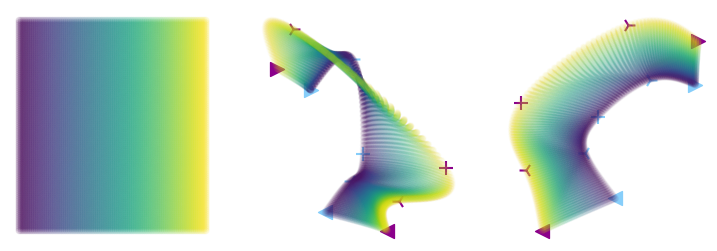

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for z_data_mmp, z_data_mmp_nr, l in zip(mmp_encoded_data, nrmmp_encoded_data, ds.labels_):
    if l[0] == 0:
        c = 'lightskyblue'
    else:
        c = 'darkmagenta'
    if l[1] == 0:
        s = 50
    else:
        s = 100
    if l[2] == 1:
        marker = '<'
    elif l[2] == 2:
        marker = '3'
    elif l[2] == 3:
        marker = '+'
    elif l[2] == 4:
        marker = '4'
    elif l[2] == 5:
        marker = '>'
    axs[1].scatter(z_data_mmp[0], z_data_mmp[1], s=s, c=c, marker=marker)
    axs[2].scatter(z_data_mmp_nr[0], z_data_mmp_nr[1], s=s, c=c, marker=marker)
axs[0].scatter(ts[:, 0], ts[:, 1], s=20, c=ts[:, 0], alpha=0.1)
axs[1].scatter(mmp_mapped[:,0], mmp_mapped[:,1], s=20, c=ts[:, 0], alpha=0.03)
axs[2].scatter(nrmmp_mapped[:,0], nrmmp_mapped[:,1], s=20, c=ts[:, 0], alpha=0.03)

for i in range(3):
    axs[i].axis('off')
plt.show()